### MINIMAL EXAMPLE OF JUPYTER NOTEBOOK WHICH CAN BE RUN WITH CROMWELL

### The problem is that it produces run2.html and trial_v1_movie_rec.gif in local folder

### IMPORT NECESSARY MODULES

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import sys
import moviepy.editor as mpy
import numpy as np
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [7]:
%matplotlib inline  
#%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Image

In [8]:
from MODULES.utilities import *
from MODULES.vae_model import * 

import torch
import pyro

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Check versions
print("pyro.__version__  --> ",pyro.__version__)
print("torch.__version__ --> ",torch.__version__)
assert(pyro.__version__.startswith('1.2'))
assert(torch.__version__.startswith('1.4'))

pyro.__version__  -->  1.2.1
torch.__version__ -->  1.4.0


## read two json files and combine in single dictionary

In [9]:
params = load_json_as_dict("parameters.json")
print(params)

{'wdl.file_train': 'gs://ld-data-bucket/data/fashionmnist_train.pkl', 'wdl.file_test': 'gs://ld-data-bucket/data/fashionmnist_test.pkl', 'wdl.file_ckpt': 'gs://ld-results-bucket/ckpt/dummy.pkl', 'wdl.bucket_output': 'gs://ld-results-bucket', 'wdl.dir_output': 'trial_v1', 'wdl.notebook_name': 'main.ipynb', 'wdl.git_repo': 'https://github.com/dalessioluca/cromwell_for_ML.git', 'wdl.commit_or_branch': 'master', 'simulation': {'__comment': 'there are 3 types of runs: scratch resume pre_trained', 'type': 'scratch'}, 'architecture': {'__comment': 'parameters specifying the architecture of the model', 'dim_zwhat': 25, 'width_input_image': 28, 'ch_input_image': 1}, 'loss': {'__comment': 'parameter of the observation model', 'mse_sigma': 0.1}, 'optimizer': {'__comment': 'which optimizer to use', 'type': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'eps': 1e-08}, 'training': {'__comment': 'parameter of the observation model', 'EPOCHS': 1, 'TEST_FREQUENCY': 5, 'CHECKPOINT_FREQUENCY': 20, 'batch_si

### prepare the file names

In [10]:
# CROMWELL will localize: 
# gs://ld-data-bucket/data/fashionmnist_train.pkl -> execution_dir/ld-data-bucket/data/fashionmnist_train.pkl
# Therefore I just need to remove  "gs://"
# Note that every path is relative to the execution_dir

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  # or whatever

train_file = remove_prefix(params["wdl.file_train"],"gs://")
test_file = remove_prefix(params["wdl.file_train"],"gs://")
ckpt_file = remove_prefix(params["wdl.file_ckpt"],"gs://")
dir_output = params["wdl.dir_output"]

# create output directionry if it does nto exists
try:
    os.mkdir(dir_output)
except FileExistsError:
    pass

# Save file to output dir
json_param_file = os.path.join(dir_output, "parameters.json")
save_dict_as_json(params,json_param_file)

# checks
assert os.path.isfile(train_file)
assert os.path.isfile(test_file)
if params["simulation"]["type"] != "scratch":
    assert os.path.isfile(ckpt_file)
    
print(train_file)
print(test_file)
print(dir_output)
print(json_param_file)

ld-data-bucket/data/fashionmnist_train.pkl
ld-data-bucket/data/fashionmnist_train.pkl
trial_v1
trial_v1/parameters.json


### get the data

In [14]:
print("get the data")
train_dataset = DatasetInMemory(train_file,use_cuda=torch.cuda.is_available())
test_dataset  = DatasetInMemory(test_file,use_cuda=torch.cuda.is_available())

get the data


Dataset lenght: 2000
imgs.shape torch.Size([8, 1, 28, 28])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


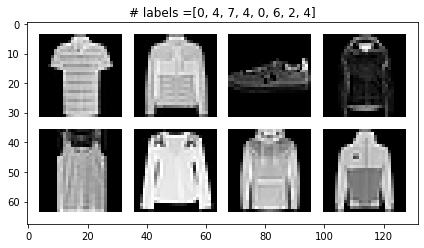

In [15]:
train_dataset.check()

Dataset lenght: 2000
imgs.shape torch.Size([8, 1, 28, 28])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


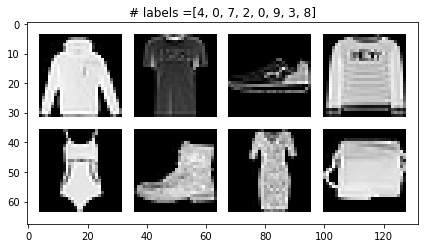

In [16]:
test_dataset.check()

### Instantiate model and optimizer

In [17]:
vae = VaeClass(params)
optimizer = instantiate_optimizer(vae, params)

### There are 3 possible simulation types: scratch, resumed, pretrained

In [20]:
print("simulation type = "+str(params["simulation"]["type"]))

if (params["simulation"]["type"] == "scratch"):
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999

elif (params["simulation"]["type"] == "resumed"):
        
    resumed = load_info(path=params["simulation"]["path_to_file"], 
                        load_epoch=True, 
                        load_history=True)
    epoch_restart = resumed.epoch
    history_dict = resumed.history_dict
    min_test_loss = min(history_dict["test_loss"])
    
    load_model_optimizer(path=params["simulation"]["path_to_file"], 
                         model=vae,
                         optimizer=optimizer)

elif (params["simulation"]["type"] == "pretrained"):
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999
    
    load_model_optimizer(path=params["simulation"]["path_to_file"], 
                         model=vae,
                         optimizer=None)
    
# instantiate the scheduler if necessary    
if params["training"]["scheduler_is_active"]:
    scheduler = instantiate_scheduler(optimizer, params)

simulation type = scratch


### Train loop

In [21]:
TEST_FREQUENCY = params["training"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = params["training"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = params["training"]["EPOCHS"]
BATCH_SIZE = params["training"]["batch_size"]

for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart
    vae.train()   
    
    #with torch.autograd.set_detect_anomaly(True):
    with torch.autograd.set_detect_anomaly(False):
        train_metrics = train_one_epoch(vae, 
                                        train_dataset, 
                                        optimizer, 
                                        BATCH_SIZE, 
                                        verbose=(epoch==0), 
                                        weight_clipper=None)
        s = pretty_print_metrics(epoch, train_metrics, is_train=True)
        print(s)
            
        
        history_dict = add_named_tuple_to_dictionary(namedtuple=train_metrics, 
                                                     dictionary=history_dict,
                                                     key_prefix="train_")
        
    if params["training"]["scheduler_is_active"]:
        scheduler.step(epoch=epoch)
    
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        test_metrics = train_one_epoch(vae, 
                                       test_dataset, 
                                       optimizer, 
                                       BATCH_SIZE, 
                                       verbose=(epoch==0), 
                                       weight_clipper=None)
        
        s = pretty_print_metrics(epoch, test_metrics, is_train=False)
        print(s)
                
        history_dict = add_named_tuple_to_dictionary(namedtuple=test_metrics, 
                                                     dictionary=history_dict,
                                                     key_prefix="test_")
        
        test_loss = test_metrics["loss"]
        min_test_loss = min(min_test_loss, test_loss)
            
        #if((test_loss == min_test_loss) or ((epoch % CHECKPOINT_FREQUENCY) == 0)): 
        if((test_loss == min_test_loss) or ((epoch % TEST_FREQUENCY) == 0)):
            checkpoint_file = os.path.join(dir_output, "ckp_"+str(epoch)+".pkl")
            history_file = os.path.join(dir_output, "history_"+str(epoch)+".pkl")
            
            save_everything(model=vae, 
                            optimizer=optimizer, 
                            history_dict=history_dict, 
                            epoch=epoch, 
                            params_dict=params, 
                            path=checkpoint_file)
            
            save_dict_as_json(history_dict, path=history_file)
            print("saved files -> "+checkpoint_file+"  "+history_file)

i =   0 train_loss=950.25525
i =   1 train_loss=781.51270
i =   2 train_loss=790.92316
i =   3 train_loss=760.10834
i =   4 train_loss=745.72638
i =   5 train_loss=695.55029
i =   6 train_loss=607.02600
i =   7 train_loss=564.29834
i =   8 train_loss=567.07349
i =   9 train_loss=571.20660
i =  10 train_loss=614.67651
i =  11 train_loss=521.01874
i =  12 train_loss=485.43469
i =  13 train_loss=523.97363
i =  14 train_loss=439.50568
i =  15 train_loss=452.71573
i =  16 train_loss=451.48984
i =  17 train_loss=442.00809
i =  18 train_loss=383.88089
i =  19 train_loss=384.78101
i =  20 train_loss=365.98987
i =  21 train_loss=396.71790
i =  22 train_loss=388.11557
i =  23 train_loss=380.59253
i =  24 train_loss=379.20563
i =  25 train_loss=355.10001
i =  26 train_loss=390.10040
i =  27 train_loss=352.17456
i =  28 train_loss=346.76379
i =  29 train_loss=348.27087
i =  30 train_loss=350.26285
i =  31 train_loss=77.91716
Train [epoch    0] loss=7.932188, kl=0.556868, nll=7.375320
i =   0 train

# Check the results

In [22]:
history_dict.keys()

dict_keys(['train_loss', 'train_kl', 'train_nll', 'test_loss', 'test_kl', 'test_nll'])

In [23]:
for k,v in history_dict.items():
    print(k," -->", history_dict[k][-3:])

train_loss  --> [7.9321882400512695]
train_kl  --> [0.5568677341938019]
train_nll  --> [7.37532039642334]
test_loss  --> [4.788099220275879]
test_kl  --> [0.7132036972045899]
test_nll  --> [4.0748954658508305]


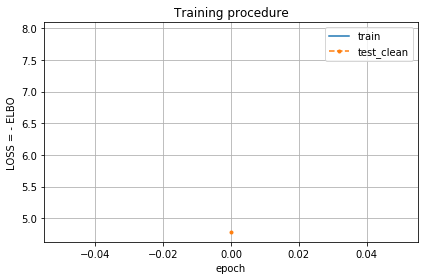

In [24]:
#plt.yscale('log')
y_shift=0
x_shift=0
sign=1

fontsize=10
fig, ax = plt.subplots(1,1)
ax.set_xlabel('REC',fontsize=fontsize)
ax.set_ylabel('REG',fontsize=fontsize)

ax.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), sign*np.array(history_dict["train_loss"])+y_shift,'-')
ax.plot(np.arange(x_shift, x_shift+len(history_dict["test_loss"])*TEST_FREQUENCY,TEST_FREQUENCY), sign*np.array(history_dict["test_loss"])+y_shift, '.--')
ax.set_xlabel('epoch')
ax.set_ylabel('LOSS = - ELBO')
ax.set_title('Training procedure')
ax.grid(True)
ax.legend(['train', 'test_clean', 'test_noisy'])

fig.tight_layout()
tmp_file = os.path.join(dir_output, "loss.png")
fig.savefig(tmp_file)

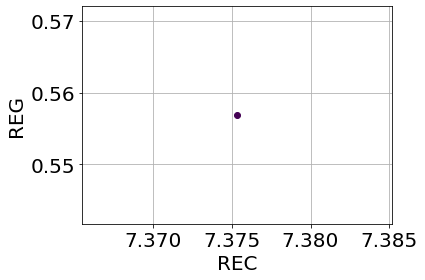

In [25]:
# Plot of KL vs evidence
fontsize=20
labelsize=20

how_many = 2000
scale= 1
N = len(history_dict["train_kl"][-how_many :])
colors = np.arange(0.0,N,1.0)/N

fig, ax = plt.subplots(1,1)
#plt.yscale('log')
#plt.xlim(xmin=1.0, xmax=1.5)
ax.set_xlabel('REC',fontsize=fontsize)
ax.set_ylabel('REG',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.scatter(history_dict["train_nll"][-how_many :], history_dict["train_kl"][-how_many :],c=colors)
ax.plot(history_dict["train_nll"][-how_many :], history_dict["train_kl"][-how_many :], '-')
ax.grid()
#plt.xlim(xmax=2.5)

fig.tight_layout()
tmp_file = os.path.join(dir_output, "rec_kl_trajectory.png")
fig.savefig(tmp_file) 

### Check reconstruction

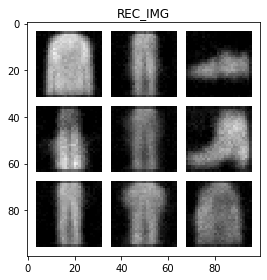

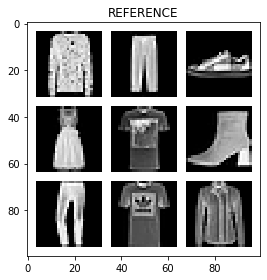

In [26]:
tmp_list = [291, 413, 133, 148, 1,2,3,4,5,6,7,8,9]
reference_imgs, labels=test_dataset.load(batch_size=9, indices=tmp_list)
metric, inference = vae.reconstruct_img(reference_imgs)

reconstruction_file = os.path.join(dir_output, "imgs_reconstructed.png")
reference_file = os.path.join(dir_output, "imgs_reference.png")

imgs_ref = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")
imgs_ref.savefig(reference_file)

imgs_rec = show_batch(inference.reconstruction, n_col=3,n_padding=4, title="REC_IMG")
imgs_rec.savefig(reconstruction_file)

display(imgs_rec, imgs_ref)

# MAKE MOVIE

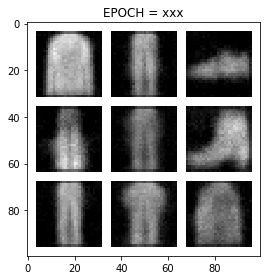

In [27]:
epoch="xxx"
a = show_batch(inference.reconstruction[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
display(a)

# actual loop

In [28]:
rec_filenames = []

for epoch in range(0,30,TEST_FREQUENCY):
    if(epoch<10):
        label ="_000"+str(epoch)
    elif(epoch<100):
        label = "_00"+str(epoch)
    elif(epoch<1000):
        label = "_0"+str(epoch)
    elif(epoch<10000):
        label = "_"+str(epoch)
    else:
        raise Exception

    try:
        checkpoint_file = os.path.join(dir_output, "ckp_"+str(epoch)+".pkl")
        _ = load_model_optimizer(path=checkpoint_file, model=vae, optimizer=None)
        metric, inference = vae.reconstruct_img(reference_imgs)
        tmp_fig = show_batch(inference.reconstruction[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        tmp_rec_file = os.path.join(dir_output, "imgs_rec"+label+".png")
        rec_filenames.append(tmp_rec_file)
        tmp_fig.savefig(tmp_rec_file, bbox_inches='tight') 
    except:
        pass

print(rec_filenames)

['trial_v1/imgs_rec_0000.png']


## Check individual images

In [29]:
def show_frame_rec(n):
    tmp = Image(filename=rec_filenames[n])
    return display(tmp)

def show_frame_all(n):
    c = Image(filename=rec_filenames[n])
    return display(c)

# make gif file

In [30]:
movie_rec_file_local = "movie_rec.gif"
movie_rec_file_absolute = os.path.join(dir_output, movie_rec_file_local)

frame_per_second = 2
im = mpy.ImageSequenceClip(rec_filenames, fps=frame_per_second)
im.write_gif(movie_rec_file_local, fps=frame_per_second)
im.write_gif(movie_rec_file_absolute, fps=frame_per_second)

MoviePy - Building file movie_rec.gif with imageio.
MoviePy - Building file trial_v1/movie_rec.gif with imageio.


In [31]:
HTML("<img src="+movie_rec_file_local+"></img>")

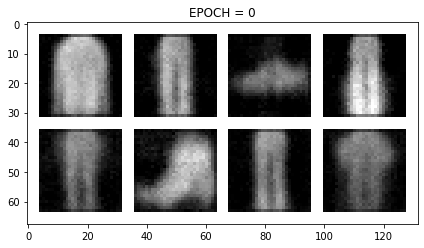

In [32]:
show_frame_rec(0)

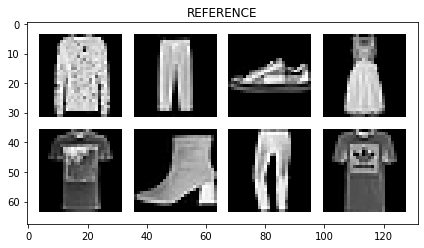

In [33]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")